<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session14/blob/main/part1_session14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install folium==0.2.1

     |████████████████████████████████| 69 kB 3.7 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=b48be1454f0e910a5cb932a54c8437e6458657341c1512f8cea65fbfe46ac58a
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [3]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers --quiet

     |████████████████████████████████| 123 kB 5.3 MB/s 
     |████████████████████████████████| 90 kB 7.3 MB/s 
     |████████████████████████████████| 176 kB 23.8 MB/s 
     |████████████████████████████████| 131 kB 43.9 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 1.2 MB 47.3 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 7.8 MB 50.9 MB/s 
     |████████████████████████████████| 138 kB 62.4 MB/s 
     |████████████████████████████████| 127 kB 64.8 MB/s 


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [7]:
!ls /drive/My\ Drive/TSAI_data/Squad2.0

dev-v2.0.json  train-v2.0.json


In [8]:
import sys
sys.path.append('/drive/My Drive/TSAI_data/Squad2.0')

In [9]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-08-12 16:14:17--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2021-08-12 16:14:17 (12.8 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2021-08-12 16:14:17--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [10]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
input_file = '/drive/My Drive/TSAI_data/Squad2.0/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [13]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [14]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
print(len(train_data))
train_data.head()

130319


,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [15]:
#we take only 20% of training data for quick training 
train_data = train_data.sample(frac=0.20)
len(train_data)

26064

In [16]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
77887,5a73acce42eae6001a38995f,What rights threaten the formation of a libera...,"[The, freedom, to, form,, declare, membership,...",,-1,-1,True


In [17]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [18]:
print_squad_sample(train_data)

CONTEXT: 
Solar concentrating technologies such as parabolic dish, trough and Scheffler reflectors can provide process
heat for commercial and industrial applications. The first commercial system was the Solar Total
Energy Project (STEP) in Shenandoah, Georgia, USA where a field of 114 parabolic dishes
provided 50% of the process heating, air conditioning and electrical requirements for a clothing
factory. This grid-connected cogeneration system provided 400 kW of electricity plus thermal energy in
the form of 401 kW steam and 468 kW chilled water, and had a
one-hour peak load thermal storage. Evaporation ponds are shallow pools that concentrate dissolved solids
through evaporation. The use of evaporation ponds to obtain salt from sea water is
one of the oldest applications of solar energy. Modern uses include concentrating brine solutions
used in leach mining and removing dissolved solids from waste streams. Clothes lines, clotheshorses,
and clothes racks dry clothes through evaporati

In [19]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
68714,572761df5951b619008f8911,How are charity or service NPOs usually organi...,"[Some, NPOs, may, also, be, a, charity, or, se...","profit corporation or as a trust, a cooperativ...",16,27,False,88,50
129578,573453f4879d6814001ca531,Who criticized the practice of Internet hunting?,"[When, Internet, hunting, was, introduced, in,...",hunters,24,24,False,85,48
66871,5ad14d10645df0001a2d1677,What does DCC stand for?,"[Found, in, applications, as, diverse, as, ind...",,-1,-1,True,116,25
88173,5ace8f0132bba1001ae4aa40,What animal contains no cells?,"[The, ""Lophotrochozoa"", hypothesis, is, also, ...",,-1,-1,True,92,30
92084,57295eafaf94a219006aa335,"In the 1800 election, why did Thomas Jefferson...","[One, elector, in, Minnesota, cast, a, ballot,...",it violated Electoral College rules,148,152,False,153,67


In [20]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.08931860036833%


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1850010.35B/s]


In [22]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [23]:
path = '/drive/My Drive/TSAI_data/Squad2.0/'

In [24]:
cached_features_file = os.path.join(path, 'cached_{}'.format('train'))

In [25]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [26]:
# features = convert_examples_to_features(examples=examples,
#                                         tokenizer=tokenizer,
#                                         max_seq_length=max_seq_length,
#                                         doc_stride=doc_stride,
#                                         max_query_length=max_query_length,
#                                         is_training=True)
# torch.save(features, cached_features_file)

In [27]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [28]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [29]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [30]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/TSAI_data/Squad2.0/checkpoint*-[0-9]*'))

In [31]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [32]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:13<00:00, 32580629.17B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [33]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0166, -0.0013,  0.0108,  ..., -0.0361,  0.0115, -0.0092],
        [ 0.0016, -0.0334,  0.0108,  ..., -0.0024,  0.0326,  0.0122]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [34]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [35]:
num_train_epochs = 2

# print("***** Running training *****")
# print("  Num examples = %d" % len(dataset))
# print("  Num Epochs = %d" % num_train_epochs)
# print("  Batch size = %d" % batch_size)
# print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        # output_dir = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-{}'.format(global_step)
        # if not os.path.exists(output_dir):
        #     os.makedirs(output_dir)
        # model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        # model_to_save.save_pretrained(output_dir)
        # torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        # print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 0/9016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  11%|█         | 1001/9016 [07:41<1:01:47,  2.16it/s]

Train loss: 1.770461499452591



Iteration:  22%|██▏       | 2001/9016 [15:22<53:59,  2.17it/s]

Train loss: 1.543778187394142



Iteration:  33%|███▎      | 3001/9016 [23:03<46:03,  2.18it/s]

Train loss: 1.4422033203144868



Iteration:  44%|████▍     | 4001/9016 [30:45<38:37,  2.16it/s]

Train loss: 1.37444586507231



Iteration:  55%|█████▌    | 5001/9016 [38:28<30:53,  2.17it/s]

Train loss: 1.320356829482317



Iteration:  67%|██████▋   | 6001/9016 [46:09<23:06,  2.17it/s]

Train loss: 1.2790163417806228



Iteration:  78%|███████▊  | 7001/9016 [53:51<15:34,  2.16it/s]

Train loss: 1.2451889236122369



Iteration:  89%|████████▊ | 8001/9016 [1:01:32<07:47,  2.17it/s]

Train loss: 1.2191383224446326



Iteration: 100%|█████████▉| 9001/9016 [1:09:13<00:06,  2.17it/s]

Train loss: 1.194316842445069



Epoch: 100%|██████████| 2/2 [1:09:25<00:00, 2082.59s/it]


In [36]:
global_step

9015

In [37]:
output_dir = '/drive/My Drive/TSAI_data/Squad2.0/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [38]:
train_loss_set_ckpt = torch.load('/drive/My Drive/TSAI_data/Squad2.0/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)


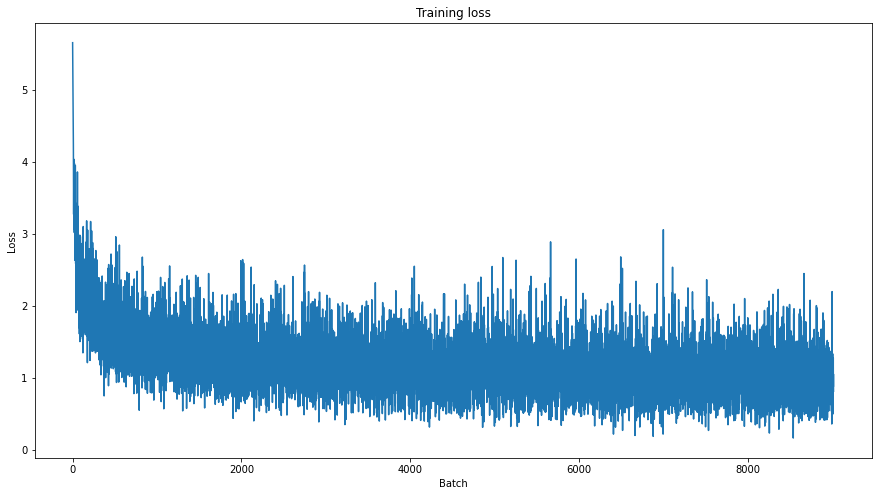

In [39]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [40]:
input_file = '/drive/My Drive/TSAI_data/Squad2.0/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = os.path.join(path, 'cached_{}'.format('validation'))

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [41]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [42]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [43]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/TSAI_data/Squad2.0//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/TSAI_data/Squad2.0/predictions.json"
  output_nbest_file = "/drive/My Drive/TSAI_data/Squad2.0/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/TSAI_data/Squad2.0/null_odds.json"
  output_dir = "/drive/My Drive/TSAI_data/Squad2.0/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [44]:
results = evaluate(model, tokenizer)

Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [02:02<00:00,  6.95it/s]


{
  "exact": 71.24568348353407,
  "f1": 74.20717125594038,
  "total": 11873,
  "HasAns_exact": 62.719298245614034,
  "HasAns_f1": 68.65076658599497,
  "HasAns_total": 5928,
  "NoAns_exact": 79.74768713204374,
  "NoAns_f1": 79.74768713204374,
  "NoAns_total": 5945,
  "best_exact": 71.51520256043123,
  "best_exact_thresh": -0.5607426166534424,
  "best_f1": 74.34441837988344,
  "best_f1_thresh": -0.4788694381713867
}


In [45]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 71.24568348353407}, {'f1': 74.20717125594038}, {'total': 11873}, {'HasAns_exact': 62.719298245614034}, {'HasAns_f1': 68.65076658599497}, {'HasAns_total': 5928}, {'NoAns_exact': 79.74768713204374}, {'NoAns_f1': 79.74768713204374}, {'NoAns_total': 5945}, {'best_exact': 71.51520256043123}, {'best_exact_thresh': -0.5607426166534424}, {'best_f1': 74.34441837988344}, {'best_f1_thresh': -0.4788694381713867}]


**Evaluate on any text**